In [51]:
import os
import numpy as np
import pandas as pd

import librosa
import librosa.display
from scipy.io import wavfile as wav

import IPython.display as ipd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

from tensorflow.keras.utils import to_categorical

# Data Exploration and Visualisation

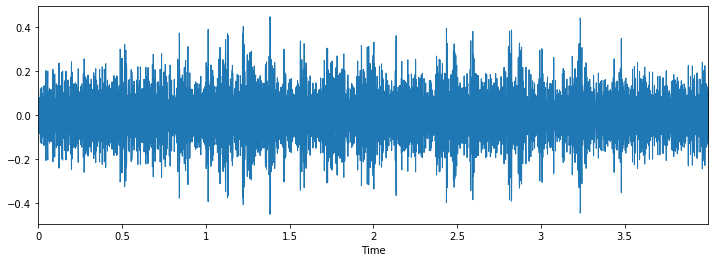

In [2]:
# Class: Air Conditioner

filename = 'datasets/UrbanSound8K/audio/fold1/134717-0-0-27.wav'
plt.figure(figsize=(12,4))
data, sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

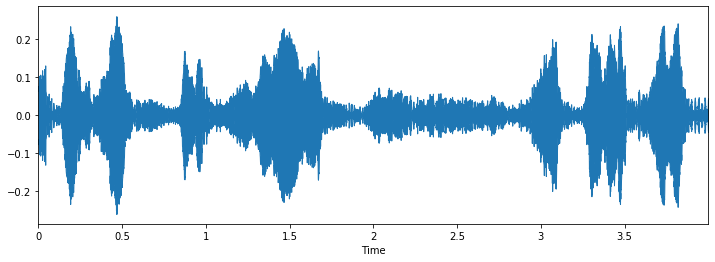

In [3]:
# Class: Children playing 

filename = 'datasets/UrbanSound8K/audio/fold1/192124-2-0-7.wav'
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [6]:
metadata = pd.read_csv('datasets/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
metadata.columns

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class_name'],
      dtype='object')

In [14]:
metadata.rename(columns={'class': 'class_name'}, inplace=True)

In [16]:
metadata.class_name.value_counts()

air_conditioner     1000
children_playing    1000
jackhammer          1000
dog_bark            1000
engine_idling       1000
street_music        1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class_name, dtype: int64

## Audio sample file properties

In [18]:
from kaymo.utils.load import read_file_properties

audiodata = []
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath('datasets/UrbanSound8K/audio/'), 
                             'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    data = read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [19]:
audiodf.head()

,num_channels,sample_rate,bit_depth
0,2,44100,16
1,2,44100,16
2,2,44100,16
3,2,44100,16
4,2,44100,16


In [22]:
audiodf.num_channels.value_counts(normalize=True)

2    0.915369
1    0.084631
Name: num_channels, dtype: float64

In [23]:
audiodf.sample_rate.value_counts(normalize=True)

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64

In [24]:
audiodf.bit_depth.value_counts(normalize=True)

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64

# Data Preprocessing & Splitting

#### Sample rate conversion
Librosa default sample rate: 22050

In [27]:
filename = 'datasets/UrbanSound8K/audio/fold2/203929-7-5-1.wav'

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 44100
Librosa sample rate: 22050


#### Bit-depth
Librosa’s load function normalise the data so it's values range between -1 and 1

In [29]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -0.38803744 to 0.38230872
Librosa audio file min~max range: -0.36076853 to 0.3447768


#### Merge audio channels
Librosa will also convert the signal to mono, meaning the number of channels will always be 1

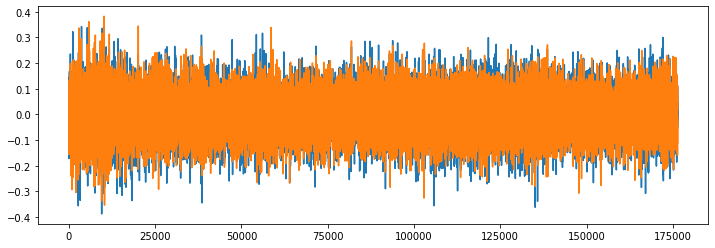

In [31]:
# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

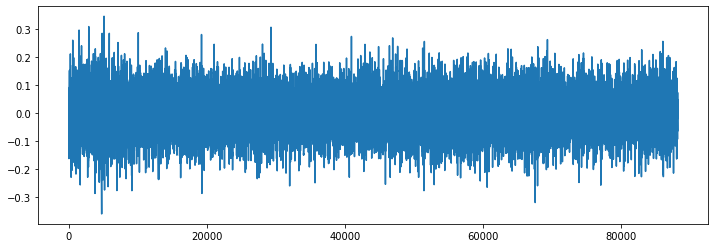

In [32]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

### Extract Features
extract Mel-Frequency Cepstral Coefficients (MFCC) from the the audio samples.

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [33]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


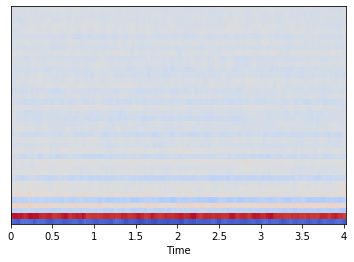

In [34]:
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [35]:
from kaymo.utils.features import extract_features

In [41]:
# Set the path to the full UrbanSound dataset 
fulldatasetpath = 'datasets/UrbanSound8K/audio/'

metadata = pd.read_csv('datasets/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.rename(columns={'class': 'class_name'}, inplace=True)

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():

    file_name = os.path.join(os.path.abspath(fulldatasetpath),
                             'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    
    class_label = row["class_name"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

Finished feature extraction from  8732  files


In [44]:
featuresdf.head()

,feature,class_label
0,"[-215.793, 71.66612, -131.81377, -52.09133, -2...",dog_bark
1,"[-424.68686, 110.562294, -54.14824, 62.01074, ...",children_playing
2,"[-459.56473, 122.80033, -47.924713, 53.265697,...",children_playing
3,"[-414.55374, 102.89688, -36.664955, 54.180405,...",children_playing
4,"[-447.39703, 115.0954, -53.809113, 61.608585, ...",children_playing


### Convert the data and labels

In [45]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

In [46]:
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

### Split the dataset

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Store the preprocessed data

In [53]:
%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)
